# Building a Recommendation System for https://www.allrecipes.com/ website

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools as it
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from joblib import Parallel, delayed

In [2]:
# Data files were given by the instrucor 

user_recipe_full = pd.read_csv('fe_user_recipe_matrix.csv')
user_recipe_train = pd.read_csv('user_recipe_matrix_train_only.csv')
recipe_ingr = pd.read_csv('fe_recipe_attribute_matrix_file84.csv')
user_recipe_train.replace(2, np.nan, inplace=True)

user_recipe_train['user_id'] = user_recipe_train.index

user_recipe_full['user_id'] = user_recipe_full.index

user_recipe_transformed = pd.melt(user_recipe_train, id_vars='user_id',
                                 var_name='recipe_name', value_name='y')
user_recipe_transformed['recipe_name'] = user_recipe_transformed['recipe_name'].apply(
    lambda x: x.split(':')[0])

user_recipe_full_transformed = pd.melt(user_recipe_full, id_vars='user_id',
                                 var_name='recipe_name', value_name='y')
user_recipe_full_transformed['recipe_name'] = user_recipe_full_transformed['recipe_name'].apply(
    lambda x: x.split(':')[0])

user_recipe_transformed = user_recipe_transformed.merge(recipe_ingr, on=['recipe_name'])

user_recipe_transformed.drop(['popularity_order'], axis=1, inplace=True)

user_recipe_transformed_train = user_recipe_transformed[~user_recipe_transformed['y'].isnull()]
user_recipe_transformed_test = user_recipe_transformed[user_recipe_transformed['y'].isnull()]

In [3]:
user_recipe_transformed_train

,user_id,recipe_name,y,random_order,butter,chicken_breast_half,tomato,Parmesan_cheese,soy_sauce,parsley,...,chorizo_sausage,onion_flake,ground_beef_chuck,puff_pastry_shell,saffron_thread,peach_preserves,rock_lobster_tail,Fontina_cheese,bake,simmer
0,0,slow-cooker-pot-roast,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,slow-cooker-pot-roast,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,slow-cooker-pot-roast,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,slow-cooker-pot-roast,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,slow-cooker-pot-roast,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,995,baked-chicken-2,1.0,1000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999996,996,baked-chicken-2,0.0,1000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999997,997,baked-chicken-2,1.0,1000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999998,998,baked-chicken-2,0.0,1000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1. Basic approaches to solve the problem

### kNN user-based approach 

#### To make recommendations in the user-based approach, one needs to calculate the following values

$$\hat{r} (u, i) = \bar{r}_u + \dfrac{\sum_{v \in U(u)} sim(u, v) (r_{v,i} - \bar{r}_v)}{\sum_{v \in U(u)} sim(u, v)}$$ where

$$sim(u, v) = corr(u, v) = \dfrac{\sum_{i=1}^n (r_{ui} - \bar{r}_u)(r_{vi} - \bar{r}_v)}{\sqrt{s^2_u s^2_v}}$$

#### The essence of the method is that we look at how certain people, similar to the user we are interested in, evaluated a specific item and recommend to our user the average rating of these people

In [4]:
# Correlation matrix for users
corr_sim_array = user_recipe_train.T.corr()

user_recipe_train.drop(['user_id'], axis=1, inplace=True)
train_array = user_recipe_train.values

In [5]:
def get_ratings_knn_user_based(sim_array: pd.DataFrame, k: int) -> np.array:
    means = np.nanmean(train_array, axis=1)
    ratings = np.zeros(train_array.shape)
    U = train_array.shape[0]

    for u in range(U):
        for i in np.argwhere(np.isnan(train_array[u])).ravel():
            rated = np.argwhere(~np.isnan(train_array[:,i])).ravel()
            all_neighbors = np.argsort(sim_array[u])
            k_neighbors = all_neighbors[np.isin(all_neighbors, rated)][-k:]
            ratings[u, i] = means[u] + np.dot(sim_array[u][k_neighbors], 
                                              train_array[:, i][k_neighbors] - 
                                              means[k_neighbors]) / np.sum(sim_array[u][k_neighbors])
            
    return ratings

### kNN item-based approach

#### To make recommendations in the item-based approach, one needs to calculate the following values

$$\hat{r} (u, i) = \bar{r}_i + \dfrac{\sum_{j \in I(i)} sim(i, j) (r_{u,j} - \bar{r}_j)}{\sum_{j \in I(i)} sim(i, j)}$$ where

$$\cos(i, j) = \dfrac{\left <i, j \right >}{\Vert i \Vert_2 \Vert j \Vert_2}$$

#### The essence of the method is that we look at how the user evaluated similar items to the desired one, and give him an average score based on his estimates of similar items.

In [6]:
# To calculate cosine similarity, you need to get rid of nan in the dataframe. You can do this by replacing nan with 0,
# because in the cosine similarity formula, adding extra zeros will not change anything.

cos_sim_array = pd.DataFrame(cosine_similarity(user_recipe_train.fillna(0)))

In [7]:
def get_ratings_knn_item_based(sim_array: pd.DataFrame, k: int) -> np.array:
    means = np.nanmean(train_array, axis=0)
    ratings = np.zeros(train_array.shape)
    I = train_array.shape[1]

    for i in range(I):
        for j in np.argwhere(np.isnan(train_array[:, i])).ravel():
            rated = np.argwhere(~np.isnan(train_array[j])).ravel()
            all_neighbors = np.argsort(sim_array[i])
            k_neighbors = all_neighbors[np.isin(all_neighbors, rated)][-k:]
            ratings[j, i] = means[i] + np.dot(sim_array[i][k_neighbors], 
                                              train_array[j][k_neighbors] - 
                                              means[k_neighbors]) / np.sum(sim_array[i][k_neighbors])
            
    return ratings

### Logit-based approach

In [8]:
def run_logistic_regression(penalty: str, C: float, solver: str) -> tuple:
    probs = np.zeros((1000, 100))

    lr = LogisticRegression(penalty=penalty, solver=solver, C=C)
    
    coeffs = []

    for user_id in user_recipe_transformed['user_id'].unique():
        X_train = user_recipe_transformed_train[user_recipe_transformed_train['user_id'] == 
                                                user_id].drop(['user_id', 'recipe_name', 'random_order', 'y'], axis=1)
        X_test = user_recipe_transformed_test[user_recipe_transformed_test['user_id'] == 
                                              user_id].drop(['user_id', 'recipe_name', 'random_order', 'y'], axis=1)
        y_train = user_recipe_transformed_train[user_recipe_transformed_train['user_id'] == user_id]['y']
        lr.fit(X_train, y_train)
        coeffs.append(lr.coef_[0])
        probs[user_id, :] = lr.predict_proba(X_test).T[1, :]
     
    return (coeffs, probs)

In [9]:
def plot_coeffs(cheddar_cheese_coeffs, cayenne_pepper_coeffs, salsa_coeffs):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].hist(cheddar_cheese_coeffs, bins=50, label='cheddar_cheese', color='orange');
    axes[0].legend(loc='upper left', frameon=False)
    axes[0].set_xlabel("Estimated coef on the feature")
    axes[0].set_ylabel("Frequency")
    
    axes[1].hist(cayenne_pepper_coeffs, bins=50, label='cayenne_pepper', color='red');
    axes[1].legend(loc='upper left', frameon=False)
    axes[1].set_xlabel("Estimated coef on the feature")
    axes[1].set_ylabel("Frequency")
    
    axes[2].hist(salsa_coeffs, bins=50, label='salsa', color='green');
    axes[2].legend(loc='upper left', frameon=False)
    axes[2].set_xlabel("Estimated coef on the feature")
    axes[2].set_ylabel("Frequency")

### Simple logistic regression 

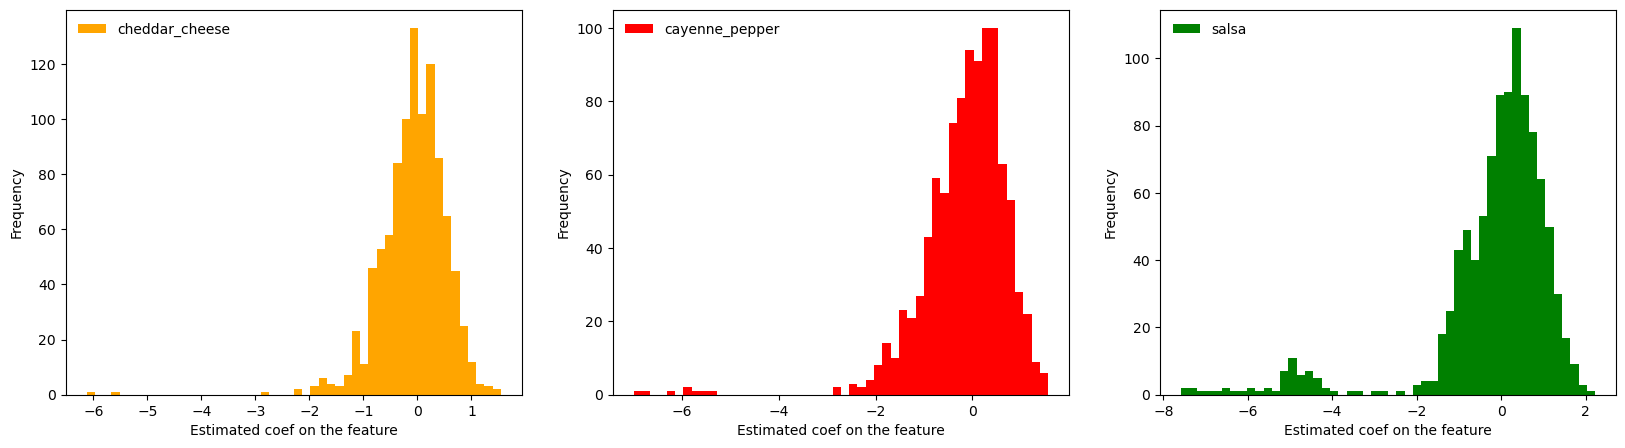

In [10]:
coeffs, probs = run_logistic_regression(penalty='none', C=1.0, solver='sag')

cheddar_cheese_coeffs = np.array(coeffs)[:, 8]
cayenne_pepper_coeffs = np.array(coeffs)[:, 9]
salsa_coeffs = np.array(coeffs)[:, np.argwhere(recipe_ingr.columns == 'salsa')[0]]
plot_coeffs(cheddar_cheese_coeffs, cayenne_pepper_coeffs, salsa_coeffs)

#### As you can see, distributions have tails on the left. This means that the coefficients for individual features are too large in modulus, which indicates the presence of retraining. This is the problem, since the model is adjusted to the training sample and then shows a bad result on new data.

#### To avoid overfitting, regularization is used, which penalizes the model for more weight. First, we implement L1-regularization, which nullifies unimportant signs. Because of this, there is such a large column at zero.

### Logistic regression with L1 regularization

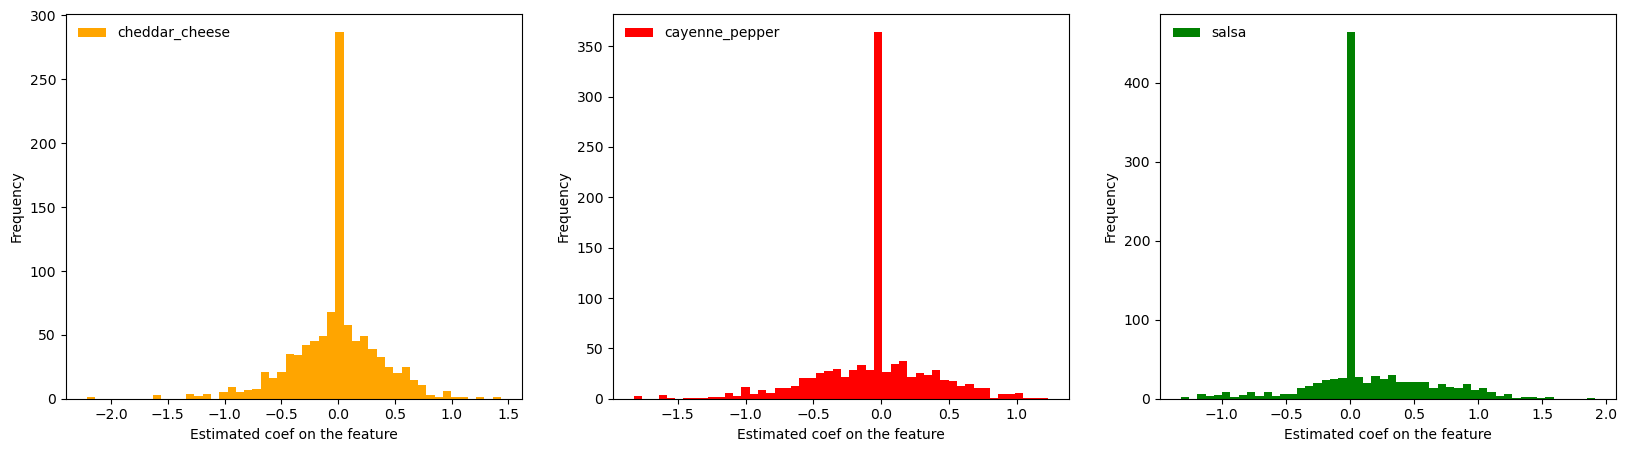

In [11]:
coeffs, probs = run_logistic_regression(penalty='l1', C=1.0, solver='saga')

cheddar_cheese_coeffs = np.array(coeffs)[:, 8]
cayenne_pepper_coeffs = np.array(coeffs)[:, 9]
salsa_coeffs = np.array(coeffs)[:, np.argwhere(recipe_ingr.columns == 'salsa')[0]]
plot_coeffs(cheddar_cheese_coeffs, cayenne_pepper_coeffs, salsa_coeffs)

#### Now let's look at L2-regularization. It also helps to reduce weight, but it is much less likely to overdo it.

### Logistic regression with L2 regularization

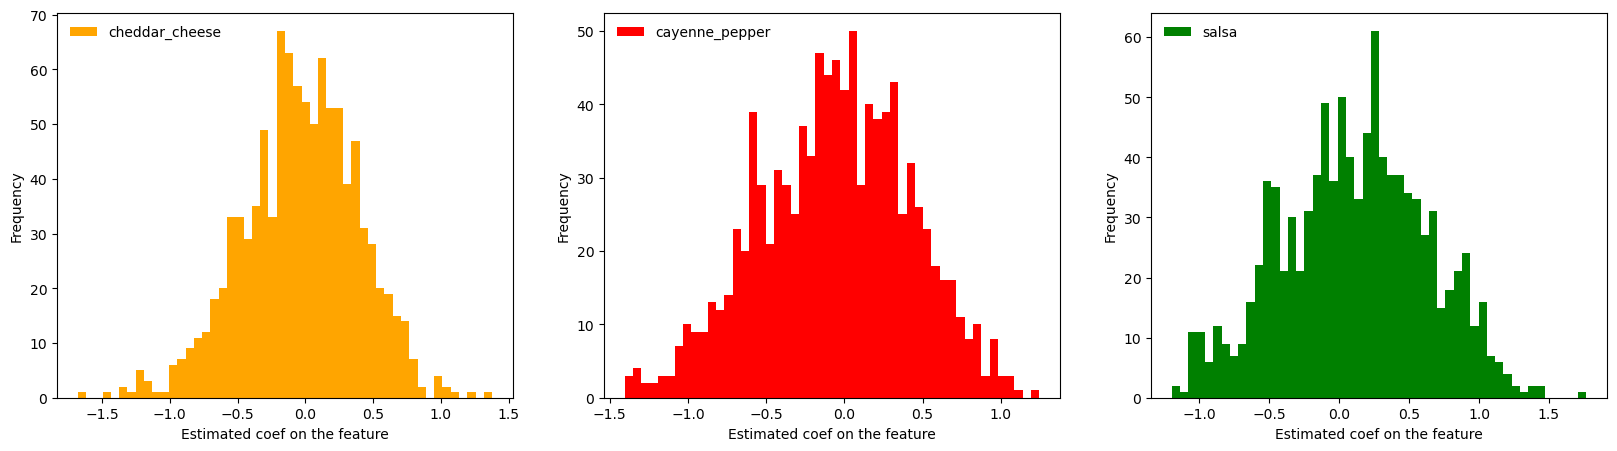

In [12]:
coeffs, probs = run_logistic_regression(penalty='l2', C=1.0, solver='sag')

cheddar_cheese_coeffs = np.array(coeffs)[:, 8]
cayenne_pepper_coeffs = np.array(coeffs)[:, 9]
salsa_coeffs = np.array(coeffs)[:, np.argwhere(recipe_ingr.columns == 'salsa')[0]]
plot_coeffs(cheddar_cheese_coeffs, cayenne_pepper_coeffs, salsa_coeffs)

#### The hyperparameter C is responsible for how much the model will be penalized for large weights, i.e. the more C, the smaller the final weights will be. It can be chosen by anyone.

## 2. Metrics

### Metrics for kNN user-based approach 

In [13]:
def get_metrics_knn(ratings: np.array, top_N: int):
    recommendations = np.argsort(ratings, axis=1)[:, -top_N:]

    TP, FP, FN, TN = 0, 0, 0, 0
    mae = np.array([])
    rmse = np.array([])

    for i in range(train_array.shape[0]):
        for j in np.argwhere(np.isnan(train_array[i])).ravel(): 
            if j in recommendations[i]:
                mae = np.append(mae, np.abs(ratings[i, j] - user_recipe_full.iloc[i, j]))
                rmse = np.append(rmse, (ratings[i, j] - user_recipe_full.iloc[i, j])**2)
            if j in recommendations[i] and user_recipe_full.iloc[i, j] == 1:
                TP += 1
            elif j in recommendations[i] and user_recipe_full.iloc[i, j] == 0:
                FP += 1
            elif j not in recommendations[i] and user_recipe_full.iloc[i, j] == 1:
                FN += 1
            elif j not in recommendations[i] and user_recipe_full.iloc[i, j] == 0:
                TN += 1
                
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)   
    
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
              'F1': F1, 'MAE': mae.mean(), 'RMSE': np.sqrt(rmse.mean())}
    return metrics

In [14]:
Ns = [1, 2, 5, 10]
ks = [10, 20]
corr_ratings = [get_ratings_knn_user_based(corr_sim_array, k) for k in ks]
corr_metrics = np.array([[get_metrics_knn(corr_ratings[i], Ns[j]) for i in range(2)] for j in range(4)])

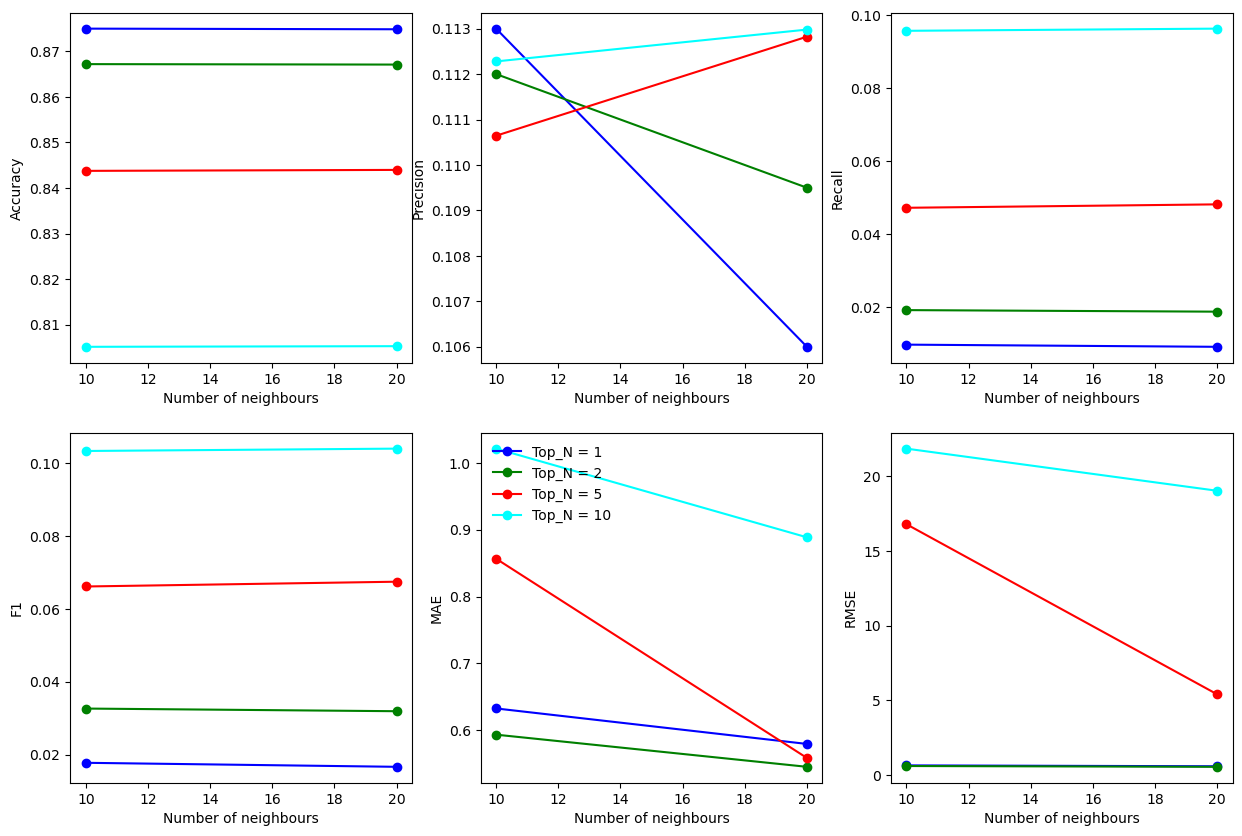

In [15]:
def plot_metrics_for_topN(metrics: np.array):
    names = ['Accuracy', 'Precision', 'Recall', 'F1', 'MAE', 'RMSE']
    agg_metrics = [[[metrics[k][i][names[j]] for i in range(len(ks))] for j in range(6)] 
                   for k in range(metrics.shape[0])]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    colors = ['blue', 'green', 'red', 'cyan']
    
    for i in range(2):
        for j in range(3):
            for k in range(metrics.shape[0]):
                if (3*i + j == 4):                 
                    axes[i, j].plot(ks, agg_metrics[k][3*i + j], color=colors[k], 
                                marker='o', label='Top_N = {0}'.format(Ns[k]))
                    axes[i, j].legend(loc='upper left', frameon=False)
                else:
                    axes[i, j].plot(ks, agg_metrics[k][3*i + j], color=colors[k], 
                                marker='o')
                axes[i, j].set_xlabel('Number of neighbours')
                axes[i, j].set_ylabel(names[3*i + j])
                axes[i, j].grid()
    plt.show() 
    
    
    
plot_metrics_for_topN(corr_metrics)

### Metrics for kNN item-based approach 

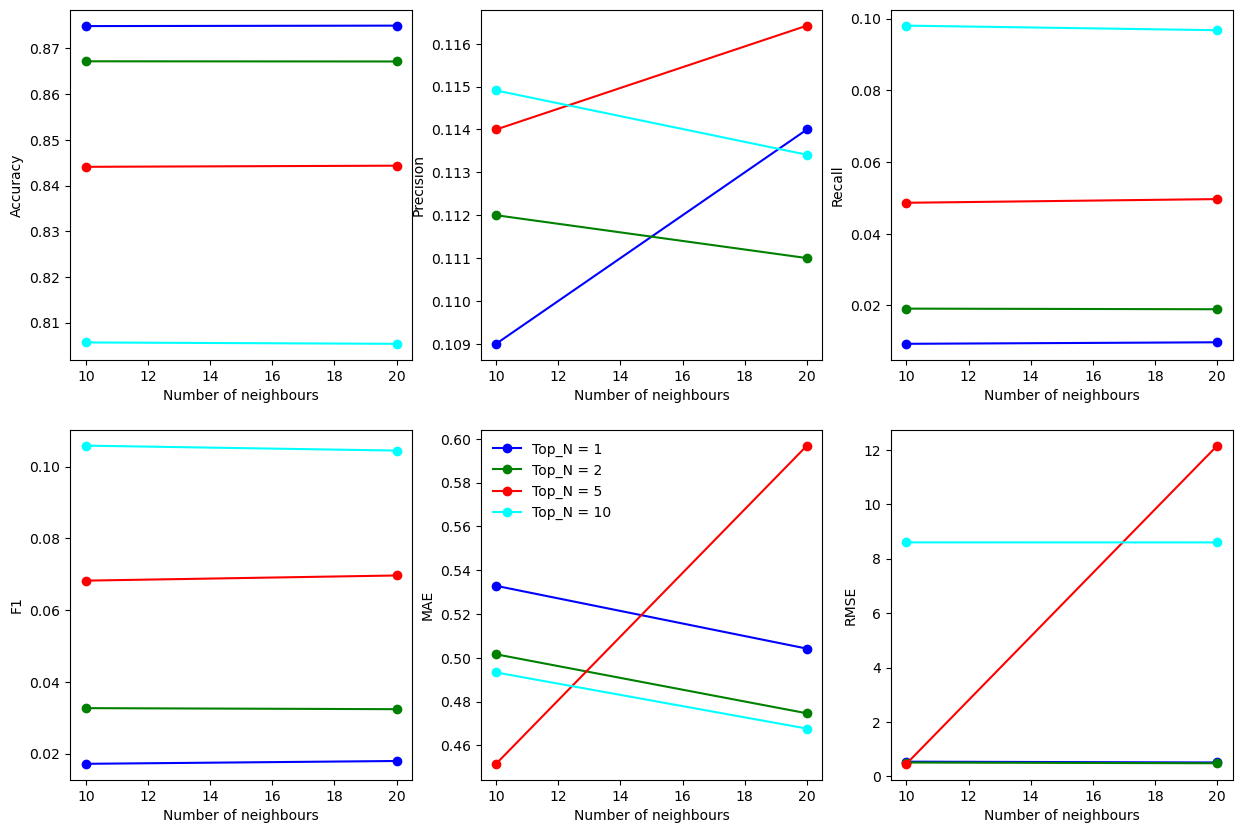

In [16]:
Ns = [1, 2, 5, 10]
ks = [10, 20]
cos_ratings = [get_ratings_knn_item_based(cos_sim_array, k) for k in ks]
cos_metrics = np.array([[get_metrics_knn(cos_ratings[i], Ns[j]) for i in range(2)] for j in range(4)])
plot_metrics_for_topN(cos_metrics)

#### In general, the two approaches show themselves approximately the same in terms of accuracy and F1. At the same time, accuracy is pretty good, on average about 84%, but F1 is very bad, on average 6%. It's a stretch to say that this will satisfy the desired result. At the same time, the item-based approach has less MAE and RMSE, which means it works more accurately. As a result, of the two methods in this case, the item-based approach copes better.

### Metrics for Logit 

In [17]:
def get_metrics_logit(probs_from_model, top_N):
    
    user_recipe_transformed_test['y_pred'] = (probs_from_model.reshape(100000,1)>0.5)*1
    df_test = user_recipe_transformed_test.drop('y',axis=1).merge(user_recipe_full_transformed[['recipe_name', 'user_id', 'y']], on=['recipe_name', 'user_id'])[['user_id', 'recipe_name', 'y', 'y_pred']]
    
    mae = np.array([])
    rmse = np.array([])
    TP, FP, FN, TN = 0, 0, 0, 0

    for user in range(1000):
        recommendations = df_test[df_test['user_id']==user].sort_values(by='y_pred', ascending=False)[:top_N]
        for n in range(recommendations.shape[0]):
            mae = np.append(mae, np.abs(recommendations.iloc[n]['y'] - recommendations.iloc[n]['y_pred']))
            rmse = np.append(rmse, (recommendations.iloc[n]['y'] - recommendations.iloc[n]['y_pred'])**2)

            if recommendations.iloc[n]['y']==1 and recommendations.iloc[n]['y_pred'] == 1:
                TP += 1
            if recommendations.iloc[n]['y']==0 and recommendations.iloc[n]['y_pred'] == 1: 
                FP += 1
            if recommendations.iloc[n]['y']==1 and recommendations.iloc[n]['y_pred'] == 0: 
                FN += 1
            if recommendations.iloc[n]['y']==0 and recommendations.iloc[n]['y_pred'] == 0: 
                TN += 1
                
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)   
    
    metrics = {'N': top_N, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
              'F1': F1, 'MAE': mae.mean(), 'RMSE': np.sqrt(rmse.mean())}
    return metrics

In [18]:
Ns = [1, 2, 5, 7, 10]
logit_metrics = np.array([get_metrics_logit(probs, Ns[j]) for j in range(len(Ns))])

In [19]:
def plot_logit_metrics_topN(logit_metrics, Ns):
    names = ['N', 'Accuracy', 'Precision', 'Recall', 'F1', 'MAE', 'RMSE']

    n = [logit_metrics[i]['N'] for i in range(len(Ns))]
    accuracy = [logit_metrics[i]['Accuracy'] for i in range(len(Ns))]
    precision = [logit_metrics[i]['Precision'] for i in range(len(Ns))]
    recall = [logit_metrics[i]['Recall'] for i in range(len(Ns))]
    f1 = [logit_metrics[i]['F1'] for i in range(len(Ns))]
    mae = [logit_metrics[i]['MAE'] for i in range(len(Ns))]
    rmse = [logit_metrics[i]['RMSE'] for i in range(len(Ns))]
    help_list = [n, accuracy, precision, recall, f1, mae, rmse]

    fig, axes = plt.subplots(6, figsize = (4,20))
    for i in range(6):
        ax = axes[i]
        ax.plot(help_list[0], help_list[i+1])
        ax.set_xlabel("top_N")
        ax.set_ylabel(names[i+1])

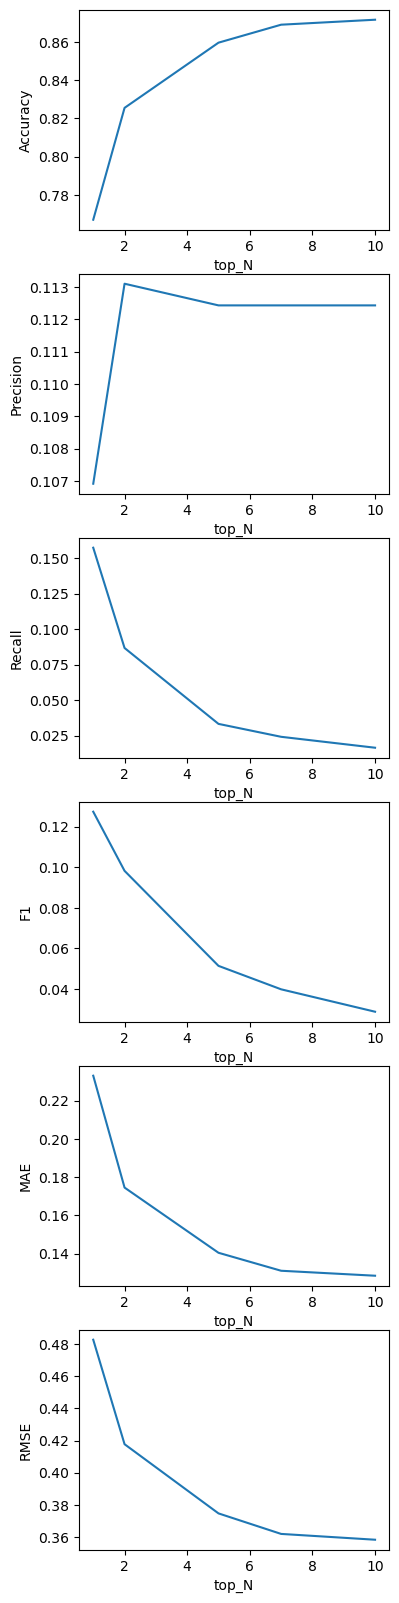

In [20]:
plot_logit_metrics_topN(logit_metrics, Ns)

#### The logic-based approach produces the same F1 and accuracy as kNN, but here MAE and RMSE are even smaller than in the kNN item-based approach. The error here is very small. It turns out that logit is the favorite among all methods.

## 3. Advanced approaches to solve the problem

### Deep Learning recommendation system 

In [21]:
user_recipe_full = pd.read_csv('fe_user_recipe_matrix.csv')
user_recipe_train = pd.read_csv('user_recipe_matrix_train_only.csv')
recipe_ingr = pd.read_csv('fe_recipe_attribute_matrix_file84.csv')

user_recipe_train.replace(2, np.nan, inplace=True)

In [22]:
# Data preprocessing 

df_melted = pd.melt(user_recipe_full, 'user_id').rename(columns = {'variable' : 'recipe', 'value' : 'liked'})
df_melted

,user_id,recipe,liked
0,10000716:0,slow-cooker-pot-roast:295,0
1,10002095:1,slow-cooker-pot-roast:295,0
2,10004231:2,slow-cooker-pot-roast:295,1
3,10009015:3,slow-cooker-pot-roast:295,1
4,10014110:4,slow-cooker-pot-roast:295,0
...,...,...,...
999995,19941788:995,baked-chicken-2:470,1
999996,1994436:996,baked-chicken-2:470,0
999997,19947462:997,baked-chicken-2:470,1
999998,19947669:998,baked-chicken-2:470,0


In [23]:
user_id_mapping = {id:i for i, id in enumerate(df_melted['user_id'].unique())}
recipe_id_mapping = {id:i for i, id in enumerate(df_melted['recipe'].unique())}
user_recipe_train['user_id'] = user_recipe_full['user_id']
df_train_melted = pd.melt(user_recipe_train, 'user_id').rename(columns = {'variable' : 'recipe', 'value' : 'liked'})
df_test = df_train_melted[df_train_melted['liked'].isna()]
df_test['liked'] = df_melted[df_train_melted['liked'].isna()]['liked']
df_train = df_train_melted[(df_train_melted['liked'].isna() == False)]
df_train

,user_id,recipe,liked
0,10000716:0,slow-cooker-pot-roast:295,0.0
1,10002095:1,slow-cooker-pot-roast:295,0.0
2,10004231:2,slow-cooker-pot-roast:295,1.0
3,10009015:3,slow-cooker-pot-roast:295,1.0
4,10014110:4,slow-cooker-pot-roast:295,0.0
...,...,...,...
999995,19941788:995,baked-chicken-2:470,1.0
999996,1994436:996,baked-chicken-2:470,0.0
999997,19947462:997,baked-chicken-2:470,1.0
999998,19947669:998,baked-chicken-2:470,0.0


In [24]:
train_user_data = df_train['user_id'].map(user_id_mapping)
train_recipe_data = df_train['recipe'].map(recipe_id_mapping)

test_user_data = df_test['user_id'].map(user_id_mapping)
test_recipe_data = df_test['recipe'].map(recipe_id_mapping)

In [25]:
def print_metrics(y_pred, y_true):
    preds = [int(i[0]) for i in y_pred > 0.5]
    acs = accuracy_score(preds, y_true)
    prec = precision_score(preds, y_true)
    rec = recall_score(preds, y_true)
    f1 = f1_score(preds, y_true)
    mse = mean_squared_error(preds, y_true)
    rmse = np.sqrt(mean_squared_error(preds, y_true))
    print('Accuracy:', acs)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1:', f1)
    print('MSE:', mse)
    print('RMSE:', rmse)

In [26]:
# Searching for the best hyperparameters of the model

n_users = len(user_id_mapping)
n_recipes = len(recipe_id_mapping)
embedding_size = 10

ues = [15, 20, 25]
res = [15, 20, 25]
den = [128, 256]
for u in ues:
    for r in res:
        for d in den:
            # Setup variables
            user_embedding_size = u
            recipe_embedding_size = r


            ##### Create model
            # Set input layers
            user_id_input = Input(shape=[1], name='user')
            recipe_id_input = Input(shape=[1], name='recipe')

            # Create embedding layers for users and movies
            user_embedding = Embedding(output_dim=user_embedding_size, 
                                    input_dim=n_users,
                                    input_length=1, 
                                    name='user_embedding')(user_id_input)
            recipe_embedding = Embedding(output_dim=recipe_embedding_size, 
                                      input_dim=n_recipes,
                                      input_length=1, 
                                      name='item_embedding')(recipe_id_input)

            # Reshape the embedding layers
            user_vector = Reshape([user_embedding_size])(user_embedding)
            recipe_vector = Reshape([recipe_embedding_size])(recipe_embedding)

            # Concatenate the reshaped embedding layers
            concat = Concatenate()([user_vector, recipe_vector])

            # Combine with dense layers
            dense = Dense(d, activation = 'relu')(concat)
            y = Dense(1)(dense)

            # Setup model
            model = Model(inputs=[user_id_input, recipe_id_input], outputs=y)
            model.compile(loss='mse', optimizer='adam')


            # Fit model
            model.fit([train_user_data, train_recipe_data],
                    df_train['liked'],
                    batch_size=256, 
                    epochs=3,
                    validation_split=0.1,
                    shuffle=True)

            # Test model
            y_pred = model.predict([test_user_data, test_recipe_data])
            y_true = df_test['liked'].values
            print(u, r, d)
            print_metrics(y_pred, y_true)

Epoch 1/3
3165/3165 [==============================] - 3s 852us/step - loss: 0.0976 - val_loss: 0.0993
Epoch 2/3
3165/3165 [==============================] - 3s 870us/step - loss: 0.0956 - val_loss: 0.1006
Epoch 3/3
3125/3125 [==============================] - 2s 491us/step
15 15 128
Accuracy: 0.88414
Precision: 0.026689478186484174
Recall: 0.6
F1: 0.05110565110565111
MSE: 0.11586
RMSE: 0.3403821381917682
Epoch 1/3
3165/3165 [==============================] - 3s 931us/step - loss: 0.0975 - val_loss: 0.0988
Epoch 2/3
3165/3165 [==============================] - 3s 964us/step - loss: 0.0956 - val_loss: 0.1007
Epoch 3/3
3125/3125 [==============================] - 2s 482us/step
15 15 256
Accuracy: 0.88388
Precision: 0.038922155688622756
Recall: 0.546875
F1: 0.07267209710908801
MSE: 0.11612
RMSE: 0.3407638478477434
Epoch 1/3
3165/3165 [==============================] - 4s 979us/step - loss: 0.0976 - val_loss: 0.0990
Epoch 2/3
3165/3165 [==============================] - 3s 938us/step - los

Epoch 1/3
3165/3165 [==============================] - 4s 1ms/step - loss: 0.0975 - val_loss: 0.0992
Epoch 2/3
3165/3165 [==============================] - 4s 1ms/step - loss: 0.0947 - val_loss: 0.1002
Epoch 3/3
3125/3125 [==============================] - 2s 473us/step
25 25 128
Accuracy: 0.88419
Precision: 0.04174508126603935
Recall: 0.5628604382929643
F1: 0.07772557139444133
MSE: 0.11581
RMSE: 0.3403086834037592
Epoch 1/3
3165/3165 [==============================] - 5s 2ms/step - loss: 0.0975 - val_loss: 0.1000
Epoch 2/3
3165/3165 [==============================] - 5s 2ms/step - loss: 0.0956 - val_loss: 0.1008
Epoch 3/3
3125/3125 [==============================] - 2s 472us/step
25 25 256
Accuracy: 0.88439
Precision: 0.03652694610778443
Recall: 0.5889655172413794
F1: 0.06878775674587194
MSE: 0.11561
RMSE: 0.34001470556433294


In [27]:
### BEST MODEL by set of metrics

# Setup variables
user_embedding_size = 15
recipe_embedding_size = 25
d = 128


##### Create model
# Set input layers
user_id_input = Input(shape=[1], name='user')
recipe_id_input = Input(shape=[1], name='recipe')

# Create embedding layers for users and movies
user_embedding = Embedding(output_dim=user_embedding_size, 
                          input_dim=n_users,
                          input_length=1, 
                          name='user_embedding')(user_id_input)
recipe_embedding = Embedding(output_dim=recipe_embedding_size, 
                            input_dim=n_recipes,
                            input_length=1, 
                            name='item_embedding')(recipe_id_input)

# Reshape the embedding layers
user_vector = Reshape([user_embedding_size])(user_embedding)
recipe_vector = Reshape([recipe_embedding_size])(recipe_embedding)

# Concatenate the reshaped embedding layers
concat = Concatenate()([user_vector, recipe_vector])

# Combine with dense layers
dense = Dense(d, activation = 'relu')(concat)
y = Dense(1)(dense)

# Setup model
model = Model(inputs=[user_id_input, recipe_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')


# Fit model
model.fit([train_user_data, train_recipe_data],
          df_train['liked'],
          batch_size = 256, 
          epochs=20,
          validation_split=0.1,
          shuffle=True)

# Test model
y_pred = model.predict([test_user_data, test_recipe_data])
y_true = df_test['liked'].values

print('\n')
print_metrics(y_pred, y_true)

Epoch 1/20
3165/3165 [==============================] - 4s 1ms/step - loss: 0.0975 - val_loss: 0.0971
Epoch 2/20
3165/3165 [==============================] - 3s 929us/step - loss: 0.0955 - val_loss: 0.0996
Epoch 3/20
3165/3165 [==============================] - 3s 1ms/step - loss: 0.0931 - val_loss: 0.1011
Epoch 4/20
3165/3165 [==============================] - 3s 1ms/step - loss: 0.0915 - val_loss: 0.1028
Epoch 5/20
3165/3165 [==============================] - 3s 1ms/step - loss: 0.0901 - val_loss: 0.1046
Epoch 6/20
3165/3165 [==============================] - 3s 1ms/step - loss: 0.0891 - val_loss: 0.1057
Epoch 7/20
3165/3165 [==============================] - 3s 960us/step - loss: 0.0882 - val_loss: 0.1056
Epoch 8/20
3165/3165 [==============================] - 3s 897us/step - loss: 0.0875 - val_loss: 0.1069
Epoch 9/20
3165/3165 [==============================] - 3s 1ms/step - loss: 0.0869 - val_loss: 0.1086
Epoch 10/20
3165/3165 [==============================] - 4s 1ms/step - loss:

In [28]:
print(model.summary())

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 recipe (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 15)        15000       ['user[0][0]']                   
                                                                                                  
 item_embedding (Embedding)     (None, 1, 25)        25000       ['recipe[0][0]']                 
                                                                                           

In [29]:
# Dataframe for validation of the model

y_pred = np.resize(y_pred,(1, 100000))
y_pred = list(y_pred)[0]
df_pred = pd.concat([pd.concat([test_user_data ,test_recipe_data], axis=1).reset_index().drop('index',axis=1), pd.Series(y_pred), pd.Series(y_true)], axis=1)
df_pred.rename(columns={0: 'proba', 1: 'y_true'}, inplace=True)
df_pred['y_pred_label'] = (df_pred['proba']>0.5)*1
df_pred

,user_id,recipe,proba,y_true,y_pred_label
0,8,0,0.126344,0,0
1,31,0,0.144010,0,0
2,59,0,0.068524,1,0
3,63,0,0.064404,0,0
4,64,0,-0.010727,0,0
...,...,...,...,...,...
99995,955,999,0.214422,0,0
99996,966,999,0.281547,0,0
99997,983,999,0.248599,0,0
99998,987,999,0.295351,0,0


In [40]:
# Example of recommendation for the concrete user

top_N = 7
df_pred[df_pred['user_id']==55].sort_values(by='proba', ascending=False)[:top_N]

,user_id,recipe,proba,y_true,y_pred_label
51879,55,518,0.747381,1,1
40684,55,407,0.623853,1,1
59873,55,598,0.567179,1,1
65523,55,654,0.544360,0,1
50457,55,504,0.516221,1,1
13847,55,140,0.487844,0,0
72672,55,726,0.474543,0,0


In [31]:
# Function for counting metrics

def get_metrics_nn(df_pred, top_N):
    
    mae = np.array([])
    rmse = np.array([])
    TP, FP, FN, TN = 0, 0, 0, 0

    for user in range(1000):
        recommendations = df_pred[df_pred['user_id']==user].sort_values(by='proba', ascending=False)[:top_N]
        for n in range(recommendations.shape[0]):
            mae = np.append(mae, np.abs(recommendations.iloc[n]['y_true'] - recommendations.iloc[n]['y_pred_label']))
            rmse = np.append(rmse, (recommendations.iloc[n]['y_true'] - recommendations.iloc[n]['y_pred_label'])**2)

            if recommendations.iloc[n]['y_true']==1 and recommendations.iloc[n]['y_pred_label'] == 1:
                TP += 1
            if recommendations.iloc[n]['y_true']==0 and recommendations.iloc[n]['y_pred_label'] == 1: 
                FP += 1
            if recommendations.iloc[n]['y_true']==1 and recommendations.iloc[n]['y_pred_label'] == 0: 
                FN += 1
            if recommendations.iloc[n]['y_true']==0 and recommendations.iloc[n]['y_pred_label'] == 0: 
                TN += 1
                
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)   
    
    metrics = {'N': top_N, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall,
              'F1': F1, 'MAE': mae.mean(), 'RMSE': np.sqrt(rmse.mean())}
    
    return metrics

In [32]:
Ns = [1, 3, 5, 10, 20, 50, 70, 100]
nn_metrics = np.array([get_metrics_nn(df_pred, Ns[j]) for j in range(len(Ns))])

In [33]:
# Metrics for the same top_N for Logistic Regression (our baseline)
# Logistic Regression showed the best performance in HW4

logit_metrics = np.array([{'N': 1, 'Accuracy': 0.767, 'Precision': 0.1069182389937107, 'Recall': 0.1574074074074074, 'F1': 0.12734082397003746, 'MAE': 0.233, 'RMSE': 0.4827007354458868},{'N': 3, 'Accuracy': 0.8466666666666667, 'Precision': 0.11242603550295859, 'Recall': 0.057750759878419454, 'F1': 0.07630522088353414, 'MAE': 0.15333333333333332, 'RMSE': 0.39157800414902433},{'N': 5, 'Accuracy': 0.8596, 'Precision': 0.11242603550295859, 'Recall': 0.03327495621716287, 'F1': 0.051351351351351354, 'MAE': 0.1404, 'RMSE': 0.3746998799039039},{'N': 10, 'Accuracy': 0.8716, 'Precision': 0.11242603550295859, 'Recall': 0.01647875108412836, 'F1': 0.028744326777609682, 'MAE': 0.1284, 'RMSE': 0.35832945734337834},{'N': 20, 'Accuracy': 0.87275, 'Precision': 0.11242603550295859, 'Recall': 0.007870753935376968, 'F1': 0.014711575687185443, 'MAE': 0.12725, 'RMSE': 0.35672117963473937},{'N': 50, 'Accuracy': 0.88254, 'Precision': 0.11242603550295859, 'Recall': 0.0033089515848136537, 'F1': 0.006428692268651666, 'MAE': 0.11746, 'RMSE': 0.34272437905699094},{'N': 70, 'Accuracy': 0.881, 'Precision': 0.11242603550295859, 'Recall': 0.002317355775094524, 'F1': 0.004541108986615678, 'MAE': 0.119, 'RMSE': 0.3449637662132068},{'N': 100, 'Accuracy': 0.88179, 'Precision': 0.11242603550295859, 'Recall': 0.0016253207869974338, 'F1': 0.003204317396070495, 'MAE': 0.11821, 'RMSE': 0.34381681168901557}],dtype=object)

In [34]:
def plot_nn_versus_logit_metrics(nn_metrics, logit_metrics, Ns):
    names = ['N', 'Accuracy', 'Precision', 'Recall', 'F1', 'MAE', 'RMSE']

    n = [nn_metrics[i]['N'] for i in range(len(Ns))]
    accuracy = [nn_metrics[i]['Accuracy'] for i in range(len(Ns))]
    precision = [nn_metrics[i]['Precision'] for i in range(len(Ns))]
    recall = [nn_metrics[i]['Recall'] for i in range(len(Ns))]
    f1 = [nn_metrics[i]['F1'] for i in range(len(Ns))]
    mae = [nn_metrics[i]['MAE'] for i in range(len(Ns))]
    rmse = [nn_metrics[i]['RMSE'] for i in range(len(Ns))]
    help_list = [n, accuracy, precision, recall, f1, mae, rmse]
    
    accuracy_1 = [logit_metrics[i]['Accuracy'] for i in range(len(Ns))]
    precision_1 = [logit_metrics[i]['Precision'] for i in range(len(Ns))]
    recall_1 = [logit_metrics[i]['Recall'] for i in range(len(Ns))]
    f1_1 = [logit_metrics[i]['F1'] for i in range(len(Ns))]
    mae_1 = [logit_metrics[i]['MAE'] for i in range(len(Ns))]
    rmse_1 = [logit_metrics[i]['RMSE'] for i in range(len(Ns))]
    help_list_1 = [n, accuracy_1, precision_1, recall_1, f1_1, mae_1, rmse_1]
    
    

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))


    for i in range(3):
        ax = axes[0, i]
        ax.plot(help_list[0], help_list[i+1], c='red', label='nn')
        ax.plot(help_list_1[0], help_list_1[i+1], label ='logit')
        ax.set_xlabel("top_N")
        ax.legend(fontsize=13)
        ax.set_ylabel(names[i+1], fontsize=18)
    for i in range(3, 6):
        ax = axes[1, i-3]
        ax.plot(help_list[0], help_list[i+1], c='red', label='nn')
        ax.plot(help_list_1[0], help_list_1[i+1], label ='logit')
        ax.set_xlabel("top_N")
        ax.legend(fontsize=13)
        ax.set_ylabel(names[i+1], fontsize=18)

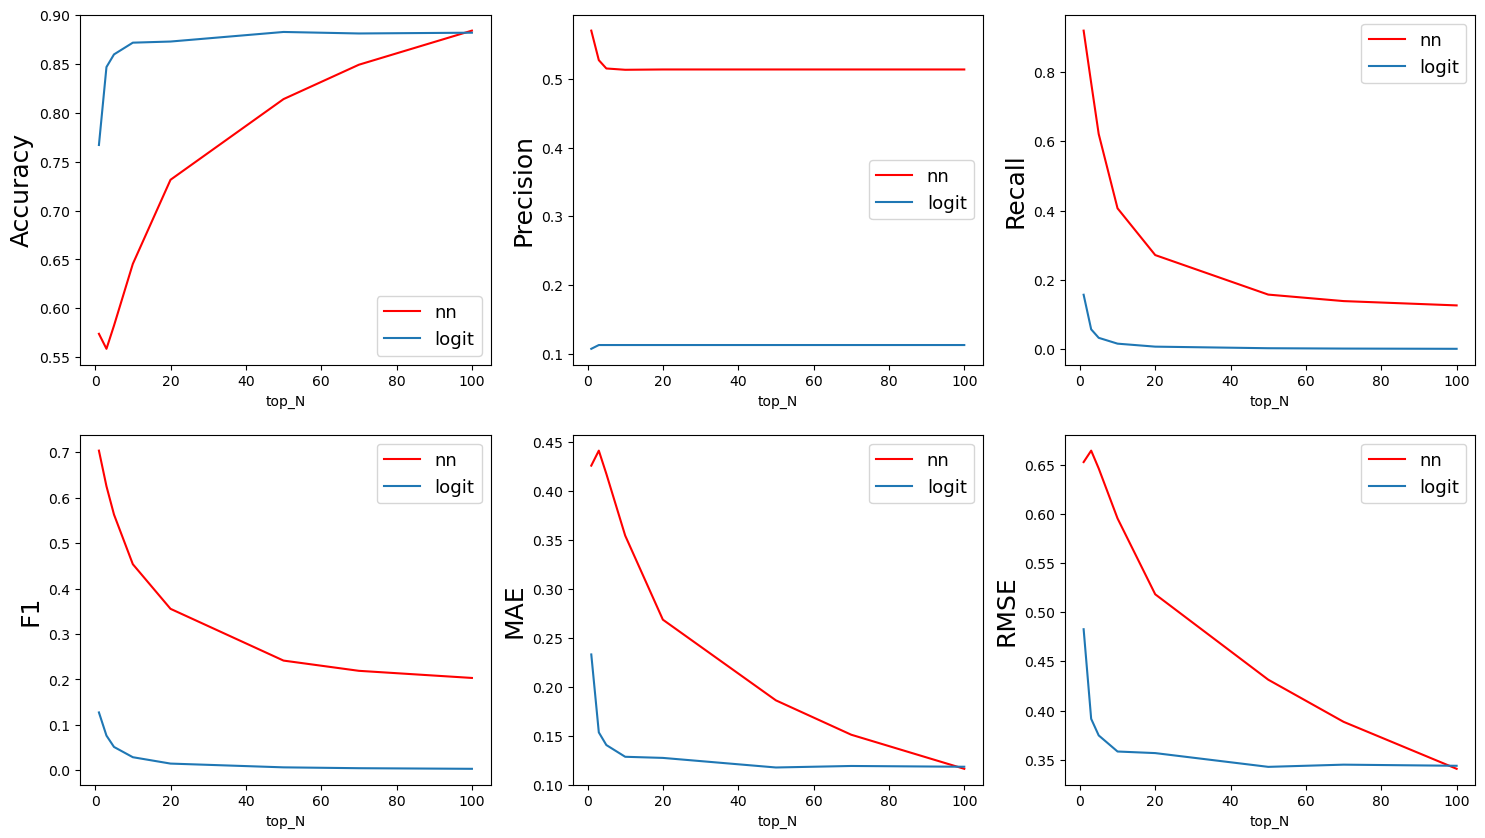

In [35]:
plot_nn_versus_logit_metrics(nn_metrics, logit_metrics, Ns)

### The DL model showed significantly better performance in both precision and recall, and, accordingly, in F1-score, so it can be argued that there was a more complex nature of data in the problem, which cannot be described by linear models. It is important to note that it is F1-score that is the most important metric for business, since the recommendation system should better predict exactly the units, that is, what the user will like, and not what he will not like, in order to subsequently issue several better recommendations. The DL model has shown a strong superiority over the baseline model, despite the fact that it loses to them in terms of losses and accuracy, although they are not important business metrics for our task.